In [1]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
lines = []
images = []
measurements = []
samples = []
with open('Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [3]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [4]:
correction = 0.25
def generator(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_name = 'Data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(center_name)
                center_image = cv2.cvtColor(center_image,cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                left_name = 'Data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(left_name)
                left_image = cv2.cvtColor(left_image,cv2.COLOR_BGR2RGB)
                left_angle = float(batch_sample[3]) + correction
                images.append(left_image)
                angles.append(left_angle)
                
                right_name = 'Data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(right_name)
                right_image = cv2.cvtColor(right_image,cv2.COLOR_BGR2RGB)
                right_angle = float(batch_sample[3]) - correction
                images.append(right_image)
                angles.append(right_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [5]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

In [6]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160,320,3)))
model.add(Cropping2D(cropping=((55,25),(0,0))))
model.add(Conv2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Conv2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Conv2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.4))
model.add(Conv2D(64,3,3,activation="relu"))
model.add(Dropout(0.4))
model.add(Conv2D(64,3,3,activation="relu"))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(.3))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

In [7]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= \
                                     3*len(train_samples), validation_data=validation_generator, \
                                     nb_val_samples=3*len(validation_samples), nb_epoch=5)

Epoch 1/5
43992/43992 [==============================] - 544s - loss: 0.0428 - val_loss: 0.0393

In [8]:
### print the keys contained in the history object
print(history_object.history.keys())

dict_keys(['loss', 'val_loss'])


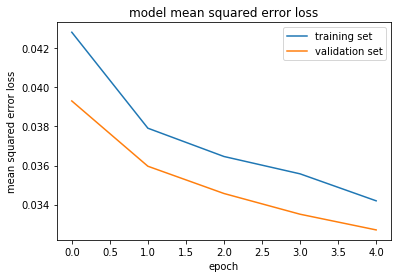

In [9]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [10]:
model.save('model.h5')